In [1]:
### JUPYTER NOTEBOOK / MODULE PATH FIX ###
import sys

if "/share/apps/python/3.8.6/intel/lib/python3.8" in sys.path and sys.path[1] == '':
    sys.path[1], sys.path[6] = sys.path[6], sys.path[1]

In [2]:
import anndata as ad
import numpy as np
import scanpy as sc
import functools
import jtb_2022_code
import gc
import inferelator_velocity as ifv
from jtb_2022_code.utils.figure_data import _gene_metadata

data = ad.read("/scratch/cj59/RAPA/2021_RAPA_TIMECOURSE.h5ad")
_gene_metadata(data)
data.var['category'] = "NA"
data.var.loc[functools.reduce(lambda x, y: x | data.var[y], [data.var['G1'], 'G2', 'M', 'M-G1', 'S']), 'category'] = "CC"
data.var.loc[functools.reduce(lambda x, y: data.var[x] | data.var[y], ['RP', 'RiBi']), 'category'] = "RP"

data.layers['counts'] = data.X.copy()
data.obs['n_counts'] = data.X.sum(axis=1).astype(int).A1
jtb_2022_code.utils.figure_data._call_cc(data)

CC_TIME_ORDER = {
    'M-G1': ('G1', 7, 22.5),
    'G1': ('S', 22.5, 39.5),
    'S': ('G2', 39.5, 56.5),
    'G2': ('M', 56.5, 77.5), 
    'M': ('M-G1', 77.5, 95)
}

RAPA_TIME_ORDER = {
    '12': ('3', -5, 5),
    '3': ('4', 5, 15),
    '4': ('5', 15, 25),
    '5': ('6', 25, 35), 
    '6': ('7', 35, 45),
    '7': ('8', 45, 55)
}   

/home/cj59/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


Loading gene names from /home/cj59/Documents/jtb_2022_code/Data/yeast_gene_names.tsv
Loading gene metadata from /home/cj59/Documents/jtb_2022_code/Data/STable6.tsv
Assigning Cell Cycle ['M-G1', 'G1', 'S', 'G2', 'M']


In [3]:
expt1_idx = data.obs['Experiment'] == 2
expt1_idx &= data.obs['Gene'] == "WT"
expt1 = ad.AnnData(data.X[expt1_idx, :].copy(), 
                   obs=data.obs.loc[expt1_idx, :].copy(),
                   var=data.var.copy(), dtype=int)

rgen = np.random.default_rng(100)
select_shuffle = np.arange(expt1.shape[0])
rgen.shuffle(select_shuffle)
expt1_test = expt1[select_shuffle[:15000], :].copy()

del expt1
del data

expt1_test.obs['Pool_Combined'] = expt1_test.obs['Pool'].astype(str)
expt1_test.obs.loc[expt1_test.obs['Pool_Combined'] == '1', 'Pool_Combined'] = '12'
expt1_test.obs.loc[expt1_test.obs['Pool_Combined'] == '2', 'Pool_Combined'] = '12'
expt1_test.layers['counts'] = expt1_test.X.copy()

gc.collect()

473

In [4]:
expt1_test

AnnData object with n_obs × n_vars = 15000 × 5843
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'CC', 'Pool_Combined'
    var: 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'category'
    layers: 'counts'

In [5]:
res = ifv.utils.knn_noise2self(expt1_test.X)
    
expt1_test.uns['opt'] = {}
expt1_test.uns['opt']['pcs'] = res[1]
expt1_test.uns['opt']['neighbors'] = res[2]
expt1_test.obs['opt_k'] = res[3]
expt1_test.obsp['opt_distances'] = res[0]

100%|██████████| 11/11 [11:14<00:00, 61.32s/it, 105 PCs]


In [6]:
expt1_test

AnnData object with n_obs × n_vars = 15000 × 5843
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'CC', 'Pool_Combined', 'opt_k'
    var: 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'category'
    uns: 'opt'
    layers: 'counts'
    obsp: 'opt_distances'

In [7]:
from inferelator_velocity import program_select, program_times, wrap_times, global_graph

global_graph(expt1_test)
program_select(expt1_test)

program_times(expt1_test, 
              {'0':  "CC", '1':  "Pool_Combined"}, 
              {'0': CC_TIME_ORDER, '1': RAPA_TIME_ORDER})

100%|██████████| 101/101 [00:37<00:00,  2.69it/s]


AnnData object with n_obs × n_vars = 15000 × 5843
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'CC', 'Pool_Combined', 'opt_k', 'program_0_time', 'program_1_time'
    var: 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'category', 'leiden', 'program'
    uns: 'opt', 'noise2self', 'programs', 'program_0_pca', 'program_1_pca'
    obsm: 'program_0_pca', 'program_1_pca'
    layers: 'counts'
    obsp: 'opt_distances', 'noise2self_distance_graph'

In [10]:
expt1_test

AnnData object with n_obs × n_vars = 15000 × 5843
    obs: 'Gene', 'Replicate', 'Pool', 'Experiment', 'n_counts', 'CC', 'Pool_Combined', 'opt_k', 'program_0_time', 'program_1_time'
    var: 'CommonName', 'G1', 'G2', 'M', 'M-G1', 'Mito', 'RP', 'RiBi', 'S', 'iESR', 'category', 'leiden', 'program'
    uns: 'opt', 'noise2self', 'programs', 'program_0_pca', 'program_1_pca'
    obsm: 'program_0_pca', 'program_1_pca'
    layers: 'counts'
    obsp: 'opt_distances', 'noise2self_distance_graph'

In [9]:
import numpy as _np
from scipy.sparse import issparse as _is_sparse
from tqdm import trange

def calc_velocity(expr, time_axis, neighbor_graph, wrap_time=None):
    """
    Calculate local RNA velocity

    :param expr: Samples x Genes numpy with expression data
    :param time_axis: Samples, numpy array
    :param neighbor_graph: Samples x Samples numpy or scipy.sparse with nearest neighbor distances
    :return: Samples x Genes numpy with velocity data
    """

    times = [_calc_local_velocity(expr[n_idx, :].copy(),
                                  time_axis[n_idx].copy(),
                                  (n_idx == i).nonzero()[0][0],
                                  wrap_time=wrap_time)
             for i, n_idx in _find_local(expr, neighbor_graph)]
    
    shape_1 = max(map(len, times))
    
    times = [np.concatenate((x, np.zeros(shape_1 - len(x), dtype=float)))
             for x in times]
    
    return np.vstack(times)


def _calc_local_velocity(expr, time_axis, center_index, wrap_time=None):
    """
    Calculate a local rate of change

    :param expr: Samples x Genes numpy with expression data
    :param time_axis: Samples, numpy array
    :param center_index: The data point which we're calculating velocity for
    :return:
    """

    n, m = expr.shape

    if _np.isnan(time_axis[center_index]):
        return _np.full(m, _np.nan)

    time_axis = time_axis - time_axis[center_index]

    if wrap_time is not None:
        time_axis = _wrap_time(time_axis, wrap_time)

    return time_axis


def _find_local(expr, neighbor_graph):
    """
    Find a return an expression matrix for a locally connected graph

    :param expr: Samples x Genes numpy or scipy with expression data
    :type expr: np.ndarray, sp.sparse.csr_matrix
    :param neighbor_graph: Samples x Samples connectivity matrix,
        where any non-zero value is connected.
    :return:
    """

    n, m = expr.shape
    neighbor_sparse = _is_sparse(neighbor_graph)

    for i in trange(n):

        n_slice = neighbor_graph[i, :]

        if neighbor_sparse:
            keepers = n_slice.indices
        else:
            keepers = _np.where(n_slice != 0)[0]

        if all(keepers != i):
            keepers = _np.insert(keepers, 0, i)

        yield i, keepers


def _wrap_time(times, wrap_time):
    """
    Wrap times by taking the minimum time difference
    with and without wrapping

    :param times: Centered time vector
    :type times: np.ndarray
    :param wrap_time: Time to wrap at
    :type wrap_time: numeric
    :return: Wrapped time vector
    :rtype: np.ndarray
    """

    times = _np.vstack((
        times + wrap_time,
        times,
        times - wrap_time
    ))

    times = times[
        _np.argmin(
            _np.abs(times),
            axis=0
        ),
        _np.arange(
            times.shape[1]
        )
    ]

    return times

_twrap = calc_velocity(
    expt1_test.X,
    expt1_test.obs['program_0_time'],
    expt1_test.obsp['noise2self_distance_graph'],
    wrap_time=88
)

100%|██████████| 15000/15000 [00:21<00:00, 688.12it/s]


In [12]:
_twrap

array([[  0.        ,  -4.27426529,  -3.11457062, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        ,   0.39295864,   1.15004921, ...,   3.61700249,
          3.24136257,  -0.0364027 ],
       [  0.        ,   2.85430527,   1.89223099, ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [  0.        ,  -0.12387085,   2.89168358, ...,  -9.74834633,
          3.65340519,   0.        ],
       [  0.        ,   1.98967743,   2.62481689, ...,   0.        ,
          0.        ,   0.        ],
       [  0.        , -15.27108383,   2.68398666, ...,   0.        ,
          0.        ,   0.        ]])

In [ ]:
_CC_TIME_SPIN = {
    'M-G1': ('G1', 51, 66.5),
    'G1': ('S', 66.5, 83.5),
    'S': ('G2', 83.5, 100.5),
    'G2': ('M', 12.5, 33.5), 
    'M': ('M-G1', 33.5, 51)
}

program_times(expt1_test, 
              {'0':  "CC", '1':  "Pool_Combined"}, 
              {'0': _CC_TIME_SPIN, '1': RAPA_TIME_ORDER})

<AxesSubplot:xlabel='program_0_time'>

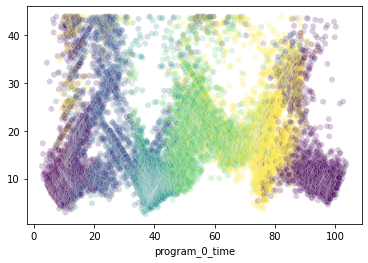

In [14]:
import seaborn as sns

_idx_sort = np.argsort(expt1_test.obs['program_0_time'])
_times = expt1_test.obs['program_0_time'].iloc[_idx_sort]
_tmeans = np.abs(_twrap).max(axis=1)[_idx_sort]

sns.scatterplot(
    x=_times,
    y=_tmeans,
    c=expt1_test.obs['CC'].cat.codes[_idx_sort],
    alpha=0.2
)

In [15]:
mean_expr = {i: np.sum(expt1_test.X[:, expt1_test.var[i]], axis=1).A1.shape for i in ['G1', 'G2', 'M', 'M-G1', 'S']}
mean_expr

{'G1': (15000,),
 'G2': (15000,),
 'M': (15000,),
 'M-G1': (15000,),
 'S': (15000,)}

In [ ]:
from jtb_2022_code.utils.dewakss_common import _do_dewakss

_do_dewakss(expt1_test)
expt1_test.layers['denoised'] = np.expm1(expt1_test.layers['denoised'])

expt1_test.write("/scratch/cj59/TEST_RAPA_DATA.h5ad")


In [ ]:
expt1_test

In [ ]:
expt1_test.layers['rapa_velocity'] = ifv.velocity.calc_velocity(
    expt1_test.layers['denoised'],
    expt1_test.obs['program_1_time'].values,
    expt1_test.obsp['denoised_distances'],
    105
)

In [ ]:
expt1_test.write("/scratch/cj59/TEST_RAPA_DATA.h5ad")

In [ ]:
import inferelator_velocity as ifv

ifv.times.wrap_times(expt1_test, '0', 88)

#ifv.pl.program_time_summary(expt1_test, '0', wrap_time=88)
ifv.pl.program_time_summary(expt1_test, '1')

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import pandas as pd
import numpy as np

def _get_colors(values, color_dict):
    """
    Convert a vector of labels to a vector of colors
    using a dict of labels -> colors

    :param values: Vector of labels
    :type values: np.ndarray
    :param color_dict: Dict of labels -> colors
    :type color_dict: dict
    :return: Vector of colors
    :rtype: np.ndarray
    """

    c = np.empty_like(values, dtype=object)
    for k, col in color_dict.items():
        c[values == k] = col

    return c


cluster_order = expt1_test.uns['program_1_pca']['cluster_order']

n = len(cluster_order)
cbar_cmap = cm.get_cmap('plasma', n)

cluster_colors = {cluster_order[i]: colors.rgb2hex(cbar_cmap(i))
                  for i in range(n)}

In [ ]:
expt1_test.uns['program_1_pca']['assignment_names']

In [ ]:
_color_vector = _get_colors(expt1_test.obs['Pool_Combined'].values, cluster_colors)
_color_vector

In [ ]:

centroids = {k: expt1_prog1.obs_names.get_loc(expt1_prog1.obs_names[expt1_prog1.obs['CC'] == k][idx])
             for k, idx in get_centroids(expt1_prog1.obsm['X_pca'], expt1_prog1.obs['CC']).items()}

centroid_cc_ids = list(centroids.keys())
centroid_indices = [centroids[k] for k in centroid_cc_ids]


In [ ]:
graph_dist, graph_pred = dijkstra(expt1_prog1.obsp['distances'], directed=False, indices=centroid_indices, return_predecessors=True)

In [ ]:
import itertools

n_centroids = len(centroid_indices)

shortest_paths = np.zeros((n_centroids, n_centroids), dtype=object)

for left, right in itertools.product(range(n_centroids), range(n_centroids)):
    start = centroid_indices[left]
    pred_arr = graph_pred[left, :]
    
    current_loc = centroid_indices[right]
    path = [current_loc]
    
    while current_loc != start:
        current_loc = pred_arr[current_loc]
        path.append(current_loc)
        
    shortest_paths[left, right] = path
    

In [ ]:
np.vectorize(len)(shortest_paths)

In [ ]:
total_path = []
total_path_centroids = {}

for i, (left, (right, _, _)) in enumerate(centroid_order.items()):
    _link_path = shortest_paths[[right == x for x in centroid_cc_ids],
                                [left == x for x in centroid_cc_ids]][0]
    
    total_path_centroids[left] = len(total_path)
    total_path.extend(_link_path[int(i > 0):])
    
step_dist = np.array([
    max(
        expt1_prog1.obsp['distances'][total_path[x], total_path[x + 1]], 
        expt1_prog1.obsp['distances'][total_path[x + 1], total_path[x]]
    ) for x in range(0, len(total_path) - 1)
])

nearest_point_on_path = dijkstra(expt1_prog1.obsp['distances'], directed=False, indices=total_path[:-1]).argmin(axis=0)

In [ ]:
func_times = _calculate_program_time(expt1_prog1.layers['counts'], expt1_prog1.obs['CC'].values, centroid_order)
func_times[func_times > 1] = func_times[func_times > 1] - 1


In [ ]:
program_times(expt1_prog1, 'CC', centroid_order, layer='counts', programs='0')

In [ ]:
ndims = 2

centroid_times = np.zeros((expt1_prog1.shape[0], n_centroids), dtype=float)    
times = np.full(expt1_prog1.shape[0], np.nan, dtype=float)    

for i, (left, (right, left_time, right_time)) in enumerate(centroid_order.items()):   
    x_right = expt1_prog1.obsm['X_pca'][centroids[right], 0:2]
    x_left = expt1_prog1.obsm['X_pca'][centroids[left], 0:2]
        
    x = x_right - x_left
    
    x_proj = np.dot(
        expt1_prog1.obsm['X_pca'][:, 0:2] - x_left, 
        x
    ) 
    x_proj = x_proj / np.linalg.norm(x)
    
    x_proj_left = x_proj[centroids[left]]
    x_proj_right = x_proj[centroids[right]]
    
    print(f"{left} / {right}: {x_proj.min()} - {x_proj.max()} [{x_proj_left} - {x_proj_right}]")

    # Normalize so left centroid is scalar 0 and right centroid is scalar 1
    x_proj = (x_proj - x_proj_left) / (x_proj_right - x_proj_left)
    
    # Convert to times
    centroid_times[:, i] = x_proj * (right_time - left_time) + left_time

    applicable_points = nearest_point_on_path >= total_path_centroids[left]
    applicable_points &= nearest_point_on_path < (total_path_centroids[right] if total_path_centroids[right] != 0 else len(total_path) - 1)
    x_app = centroid_times[applicable_points, i]
    
    times[applicable_points] = centroid_times[applicable_points, i]
       
    print(f"{left} / {right}: {x_app.min()} - {x_app.max()} [{centroid_times[centroids[left], i]} - {centroid_times[centroids[right], i]}]")

    
#for i, (left, (right, left_time, right_time)) in enumerate(centroid_order.items()):
#    right = total_path_centroids[right] if right != 'M-G1' else len(total_path[:-1])
#    applicable_points = nearest_point_on_path >= total_path_centroids[left]
#    applicable_points &= nearest_point_on_path < right
#    times[applicable_points] = np.dot(expt1_prog1.obsm['X_pca'][applicable_points, 0:ndims], 
#                                      regression_coefs[i, :])

times[times > 1] = times[times > 1] - 1
    
print(f"Times: {times.min()} - {times.max()} [0 - 1]")

In [ ]:
x_proj

In [ ]:
import matplotlib.pyplot as plt
from jtb_2022_code.figure_constants import *
from jtb_2022_code.utils.figure_common import *
import pandas as pd

fig, axd = plt.subplot_mosaic([['prog1_pca', 'M-G1', 'G1'], ['prog1_pca_2', 'S', 'G2'], ['pca_cc_cbar', 'M', 'hist']],
                              gridspec_kw=dict(width_ratios=[1, 1, 1], 
                                               height_ratios=[1, 1, 1],
                                               wspace=0.3, hspace=0.3), 
                              figsize=(6, 6), dpi=300)

def _get_time_hist(data, groups, min_time, max_time):
    cuts = np.arange(min_time, max_time + 1)
    return [np.bincount(pd.cut(data[groups == x], 
                               cuts, labels=np.arange(len(cuts) - 1)).dropna(),
                        minlength=len(cuts) - 1) for x in CC_COLS]

def plt_time_histogram(times, groups, ax, bins=50):
    
    hist_limit, fref = [], []
    hist_labels = np.linspace(0.5, bins - 0.5, bins)
    
    bottom_line = None
    for j, hist_data in enumerate(_get_time_hist(times * bins, groups, 0, bins)):

        bottom_line = np.zeros_like(hist_data) if bottom_line is None else bottom_line

        fref.append(ax.bar(hist_labels, 
                           hist_data, 
                           bottom=bottom_line, 
                           width=0.5, 
                           color=cc_palette()[j]))

        bottom_line = bottom_line + hist_data

        hist_limit.append(np.max(np.abs(bottom_line)))

    hist_limit = max(hist_limit)
    ax.set_ylim(0, hist_limit)
    ax.set_xlabel("Time [min]")
    ax.set_xlim(0, bins)
                        
    return fref

rgen = np.random.default_rng(123)
overplot_shuffle = np.arange(expt1_prog1.X.shape[0])
rgen.shuffle(overplot_shuffle)

_xlim = expt1_prog1.obsm['X_pca'][:, 0].min(), expt1_prog1.obsm['X_pca'][:, 0].max()
_ylim = expt1_prog1.obsm['X_pca'][:, 1].min(), expt1_prog1.obsm['X_pca'][:, 1].max()


axd['prog1_pca'].set_title("Program PCA")

axd['prog1_pca'].scatter(expt1_prog1.obsm['X_pca'][overplot_shuffle, 0], expt1_prog1.obsm['X_pca'][overplot_shuffle, 1], 
                      c=expt1_prog1.obs['CC'].map({k: v for k, v in zip(CC_COLS, cc_palette())}).values[overplot_shuffle],
                      s=1, alpha=0.5)

axd['prog1_pca'].scatter(expt1_prog1.obsm['X_pca'][centroid_indices, 0], expt1_prog1.obsm['X_pca'][centroid_indices, 1], 
                         c='None', edgecolor='black',
                         s=150, alpha=1)

axd['prog1_pca'].plot(expt1_prog1.obsm['X_pca'][total_path, 0], expt1_prog1.obsm['X_pca'][total_path, 1], 
                      '-ok', color='black', markersize=3, linewidth=1)

axd['prog1_pca'].set_yticklabels([])
axd['prog1_pca'].set_xticklabels([])
axd['prog1_pca'].set_xticks([])
axd['prog1_pca'].set_yticks([])
axd['prog1_pca'].set_xlabel("PC1")
axd['prog1_pca'].set_ylabel("PC2")
axd['prog1_pca'].set_xlim(_xlim)
axd['prog1_pca'].set_ylim(_ylim)


for i, (left, (right, left_time, right_time)) in enumerate(centroid_order.items()):
    axd['prog1_pca'].plot(expt1_prog1.obsm['X_pca'][[centroids[left], centroids[right]], 0], 
                          expt1_prog1.obsm['X_pca'][[centroids[left], centroids[right]], 1],
                          ls = '--', color='black',
                          alpha = 0.5,
                          lw = 1)
    
axd['prog1_pca_2'].scatter(expt1_prog1.obsm['X_pca'][overplot_shuffle, 0], expt1_prog1.obsm['X_pca'][overplot_shuffle, 2], 
                           c=expt1_prog1.obs['CC'].map({k: v for k, v in zip(CC_COLS, cc_palette())}).values[overplot_shuffle],
                           s=1, alpha=0.5)
axd['prog1_pca_2'].set_xlabel("PC1")
axd['prog1_pca_2'].set_ylabel("PC3")
axd['prog1_pca_2'].set_yticklabels([])
axd['prog1_pca_2'].set_xticklabels([])
axd['prog1_pca_2'].set_xticks([])
axd['prog1_pca_2'].set_yticks([])
axd['prog1_pca_2'].set_xlim(_xlim)
axd['prog1_pca_2'].set_ylim(_ylim)

for i, (left, (right, left_time, right_time)) in enumerate(centroid_order.items()):
    applicable_points = nearest_point_on_path >= total_path_centroids[left]
    applicable_points &= nearest_point_on_path < (total_path_centroids[right] if right != 'M-G1' else len(total_path[:-1]))
    
    axd[left].scatter(expt1_prog1.obsm['X_pca'][applicable_points, 0], expt1_prog1.obsm['X_pca'][applicable_points, 1], 
                      c=expt1_prog1.obs['CC'].map({k: v for k, v in zip(CC_COLS, cc_palette())}).values[applicable_points],
                      s=1, alpha=0.5)
    
    axd[left].scatter(expt1_prog1.obsm['X_pca'][[centroids[left], centroids[right]], 0], 
                      expt1_prog1.obsm['X_pca'][[centroids[left], centroids[right]], 1], 
                      c='None', edgecolor='black',
                      s=150, alpha=1)
    
    _right = total_path_centroids[right] if total_path_centroids[right] != 0 else len(total_path) - 1
    axd[left].plot(expt1_prog1.obsm['X_pca'][total_path[max(total_path_centroids[left] - 1, 0):_right], 0], 
                   expt1_prog1.obsm['X_pca'][total_path[max(total_path_centroids[left] - 1, 0):_right], 1], 
                   '-ok', color='black', markersize=3, linewidth=1)
    
    axd[left].set_title(f"{left} / {right}")
    axd[left].set_xticklabels([])
    axd[left].set_yticklabels([])
    axd[left].set_xlim(_xlim)
    axd[left].set_ylim(_ylim)
    
plt_time_histogram(func_times, expt1_prog1.obs['CC'], axd['hist'], bins=88)
axd['hist'].set_title("Cell Times")
    
add_legend(axd['pca_cc_cbar'], cc_palette(), CC_COLS, title="Phase")
axd['pca_cc_cbar'].axis('off')

In [ ]:
np.quantile(times, (0.05, 0.95))

In [ ]:
_all_points

In [ ]:
print(len(total_path))
sum(x == y for y in total_path for x in total_path)

In [ ]:
import matplotlib.pyplot as plt

from jtb_2022_code.figure_constants import *
from jtb_2022_code.utils.figure_common import *

fig, axd = plt.subplot_mosaic([['prog1_pca', 'pca_cc_cbar'], ['prog1_hist', 'pca_t_cbar']],
                              gridspec_kw=dict(width_ratios=[1, 0.2], 
                                               height_ratios=[1, 1],
                                               wspace=0.25, hspace=0.25), 
                              figsize=(4, 4), dpi=300)

rgen = np.random.default_rng(123)
overplot_shuffle = np.arange(expt1_prog1.X.shape[0])
rgen.shuffle(overplot_shuffle)


axd['prog1_pca'].set_title("Program PCA")

axd['prog1_pca'].scatter(expt1_prog1.obsm['X_pca'][overplot_shuffle, 0], expt1_prog1.obsm['X_pca'][overplot_shuffle, 1], 
                      c=expt1_prog1.obs['CC'].map({k: v for k, v in zip(CC_COLS, cc_palette())}).values[overplot_shuffle],
                      s=1, alpha=0.5)

axd['prog1_pca'].scatter(expt1_prog1.obsm['X_pca'][centroid_indices, 0], expt1_prog1.obsm['X_pca'][centroid_indices, 1], 
                         c='None', edgecolor='black',
                         s=150, alpha=1)

axd['prog1_pca'].plot(expt1_prog1.obsm['X_pca'][total_path, 0], expt1_prog1.obsm['X_pca'][total_path, 1], 
                      '-ok', color='black', markersize=3, linewidth=1)

axd['prog1_pca'].set_yticklabels([])
axd['prog1_pca'].set_xticklabels([])
axd['prog1_pca'].set_xticks([])
axd['prog1_pca'].set_yticks([])

for i, (left, (right, left_time, right_time)) in enumerate(centroid_order.items()):
    axd['prog1_pca'].axline(expt1_prog1.obsm['X_pca'][centroids[left], 0:2], 
                            expt1_prog1.obsm['X_pca'][centroids[right], 0:2],
                            ls = '--', color='black',
                            alpha = 0.5,
                            lw = 1)

axd['prog1_hist'].scatter(times[overplot_shuffle], np.random.rand(len(times)), c=expt1_prog1.obs['CC'].map({k: v for k, v in zip(CC_COLS, cc_palette())}).values[overplot_shuffle],
                          s=1, alpha=0.5)

add_legend(axd['pca_t_cbar'], pool_palette(), list(range(1, 9)), title="Time")
axd['pca_t_cbar'].axis('off')

add_legend(axd['pca_cc_cbar'], cc_palette(), CC_COLS, title="Phase")
axd['pca_cc_cbar'].axis('off')

In [ ]:
centroid_indices